<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-оттока-клиентов-телеком-компании" data-toc-modified-id="Прогнозирование-оттока-клиентов-телеком-компании-1">Прогнозирование оттока клиентов телеком компании</a></span></li><li><span><a href="#Ознакомление-с-проектом" data-toc-modified-id="Ознакомление-с-проектом-2">Ознакомление с проектом</a></span><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-2.1">Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2.2">Описание данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2.3">Изучение данных</a></span></li></ul></li><li><span><a href="#Предобработка--данных" data-toc-modified-id="Предобработка--данных-3">Предобработка  данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4">Исследовательский анализ данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения-моделей" data-toc-modified-id="Подготовка-данных-для-обучения-моделей-5">Подготовка данных для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6">Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.1">Logistic Regression</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-6.2">Random Forest Classifier</a></span></li><li><span><a href="#Cat-Boost-Classifier" data-toc-modified-id="Cat-Boost-Classifier-6.3">Cat Boost Classifier</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-7">Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Анализ-важности-факторов" data-toc-modified-id="Анализ-важности-факторов-8">Анализ важности факторов</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-9">Выводы</a></span></li><li><span><a href="#Отчет-по-выполненной-работе" data-toc-modified-id="Отчет-по-выполненной-работе-10">Отчет по выполненной работе</a></span></li></ul></div>

# Прогнозирование оттока клиентов телеком компании 

# Ознакомление с проектом

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

RANDOM_STATE = 120922

In [2]:
try:
    contract_df = pd.read_csv('contract.csv')
    personal_df = pd.read_csv('personal.csv')
    internet_df = pd.read_csv('internet.csv')
    phone_df = pd.read_csv('phone.csv')
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def info_df(df):
    display(df.head(5))
    display(df.describe())
    df.info()
    
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled

def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

In [4]:
info_df(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract_df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [6]:
contract_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

- в датафрейме нет пропусков
- столбец TotalCharges нужно перевести в числовой тип
- столбцы BeginDate и EndDate нужно перевести в формат даты
- No в столбце EndDate означает что клиент все еще пользуется услугами компании
- по столбцу EndDate мы можем определить целевой признак для обучения модели
- customerID нужно переименовать в СustomerID        

In [7]:
info_df(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


- в датафрейме нет пропусков
- customerID и gender нужно переименовать в CustomerID и Gender
- Gender, Partner и Dependents следует закодировать методом OHE

In [8]:
info_df(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1591-MQJTP,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
internet_df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

- в датафрейме нет пропусков
- customerID нужно переименовать в CustomerID
- данные есть не по всем клиентам
- к датафрейму следует применить кодирование категориальных признаков методом OHE

In [10]:
info_df(phone_df)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1730-ZMAME,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


- в датафрейме нет пропусков
- данные есть не по всем клиентам
- customerID нужно переименовать в CustomerID
- MultipleLines следует закодировать методом OHE

Предполагаемый план работ:
- провести детальное изучение датафреймов(наличие пропусков, дубликатов, несоответствие типов данных, необходимость преобразования данных)
- провести подготовку данных, основываясь на результатах предыдущих действий
- провести исследовательский анализ данных (поиск зависимостей, визуализация - графики, гистограммы, поиск выбросов и оценка их влияния на дальнейшую работу)
- обучение нескольких моделей, подбор параметров для них
- оценка качества моделей по выбранным метрикам
- итоговые выводы, рекомендации для бизнеса

# Предобработка  данных

Переименуем столбцы в каждом датафрейме.

In [11]:
contract_df = contract_df.rename(columns={'customerID': 'CustomerID'})
personal_df = personal_df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
internet_df = internet_df.rename(columns={'customerID': 'CustomerID'})
phone_df = phone_df.rename(columns={'customerID': 'CustomerID'})

In [12]:
print(contract_df.columns.values)
print(personal_df.columns.values)
print(internet_df.columns.values)
print(phone_df.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']
['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']
['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']
['CustomerID' 'MultipleLines']


Если в столбце EndDate стоит No, соответственно клиент продолжает пользоваться услугами телеком компании. Создадим новый столбец DepartedClient, показывающий ушел клиент или продолжает пользоваться услугами. 

In [13]:
contract_df['DepartedClient'] = (contract_df['EndDate'] != 'No').astype(int)
contract_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DepartedClient
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Проверим дату выгрузки данных.

In [14]:
contract_df['BeginDate'].max()

'2020-02-01'

Заменим в столбце EndDate No на дату выгрузки данных.

In [15]:
contract_df['EndDate'] = contract_df['EndDate'].replace(['No'], ['2020-02-01'])

In [16]:
contract_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DepartedClient
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Изменим тип данных столбцов BeginDate и EndDate на datetime.

In [17]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   DepartedClient    7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Создадим новый столбец TotalDays, показывающий сколько всего дней пользовался(пользуется) услугами клиент.

In [18]:
contract_df['TotalDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

Преобразуем тип данных столбца TotalCharges на числовой.

In [19]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors ='coerce')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   DepartedClient    7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Видим, что в столбце TotalCharges появились пропуски. Просмотрим их.

In [20]:
contract_df[contract_df['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DepartedClient,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Очевидно пропуски появились из-за того, что это новые клиенты. Заменим пропуски на ноль.

In [21]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(0)
contract_df['TotalCharges'].isnull().sum()

0

Объединим все таблицы в одну по столбцу CustomerID.

In [22]:
final_df = contract_df.merge(personal_df, how='left', on='CustomerID')\
                      .merge(internet_df, how='left', on='CustomerID')\
                      .merge(phone_df, how='left', on='CustomerID')

In [23]:
info_df(final_df)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DepartedClient,TotalDays,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,DepartedClient,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   DepartedClient    7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

В столбцах 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' появились пропуски. Скорее всего клиенты не пользуются этими допуслугами, заменим пропуски на значение No.

In [24]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    final_df[column] = final_df[column].fillna('No')

In [25]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   DepartedClient    7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

Данные готовы для анализа.

# Исследовательский анализ данных

Выделим группы количественных и категориальных признаков.

In [26]:
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']

Проанализируем распредления категориальных признаков.

In [27]:
cols = 3
rows = int(np.ceil(len(categorial_columns) / cols))

plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 30

Text(0, 0.5, '')

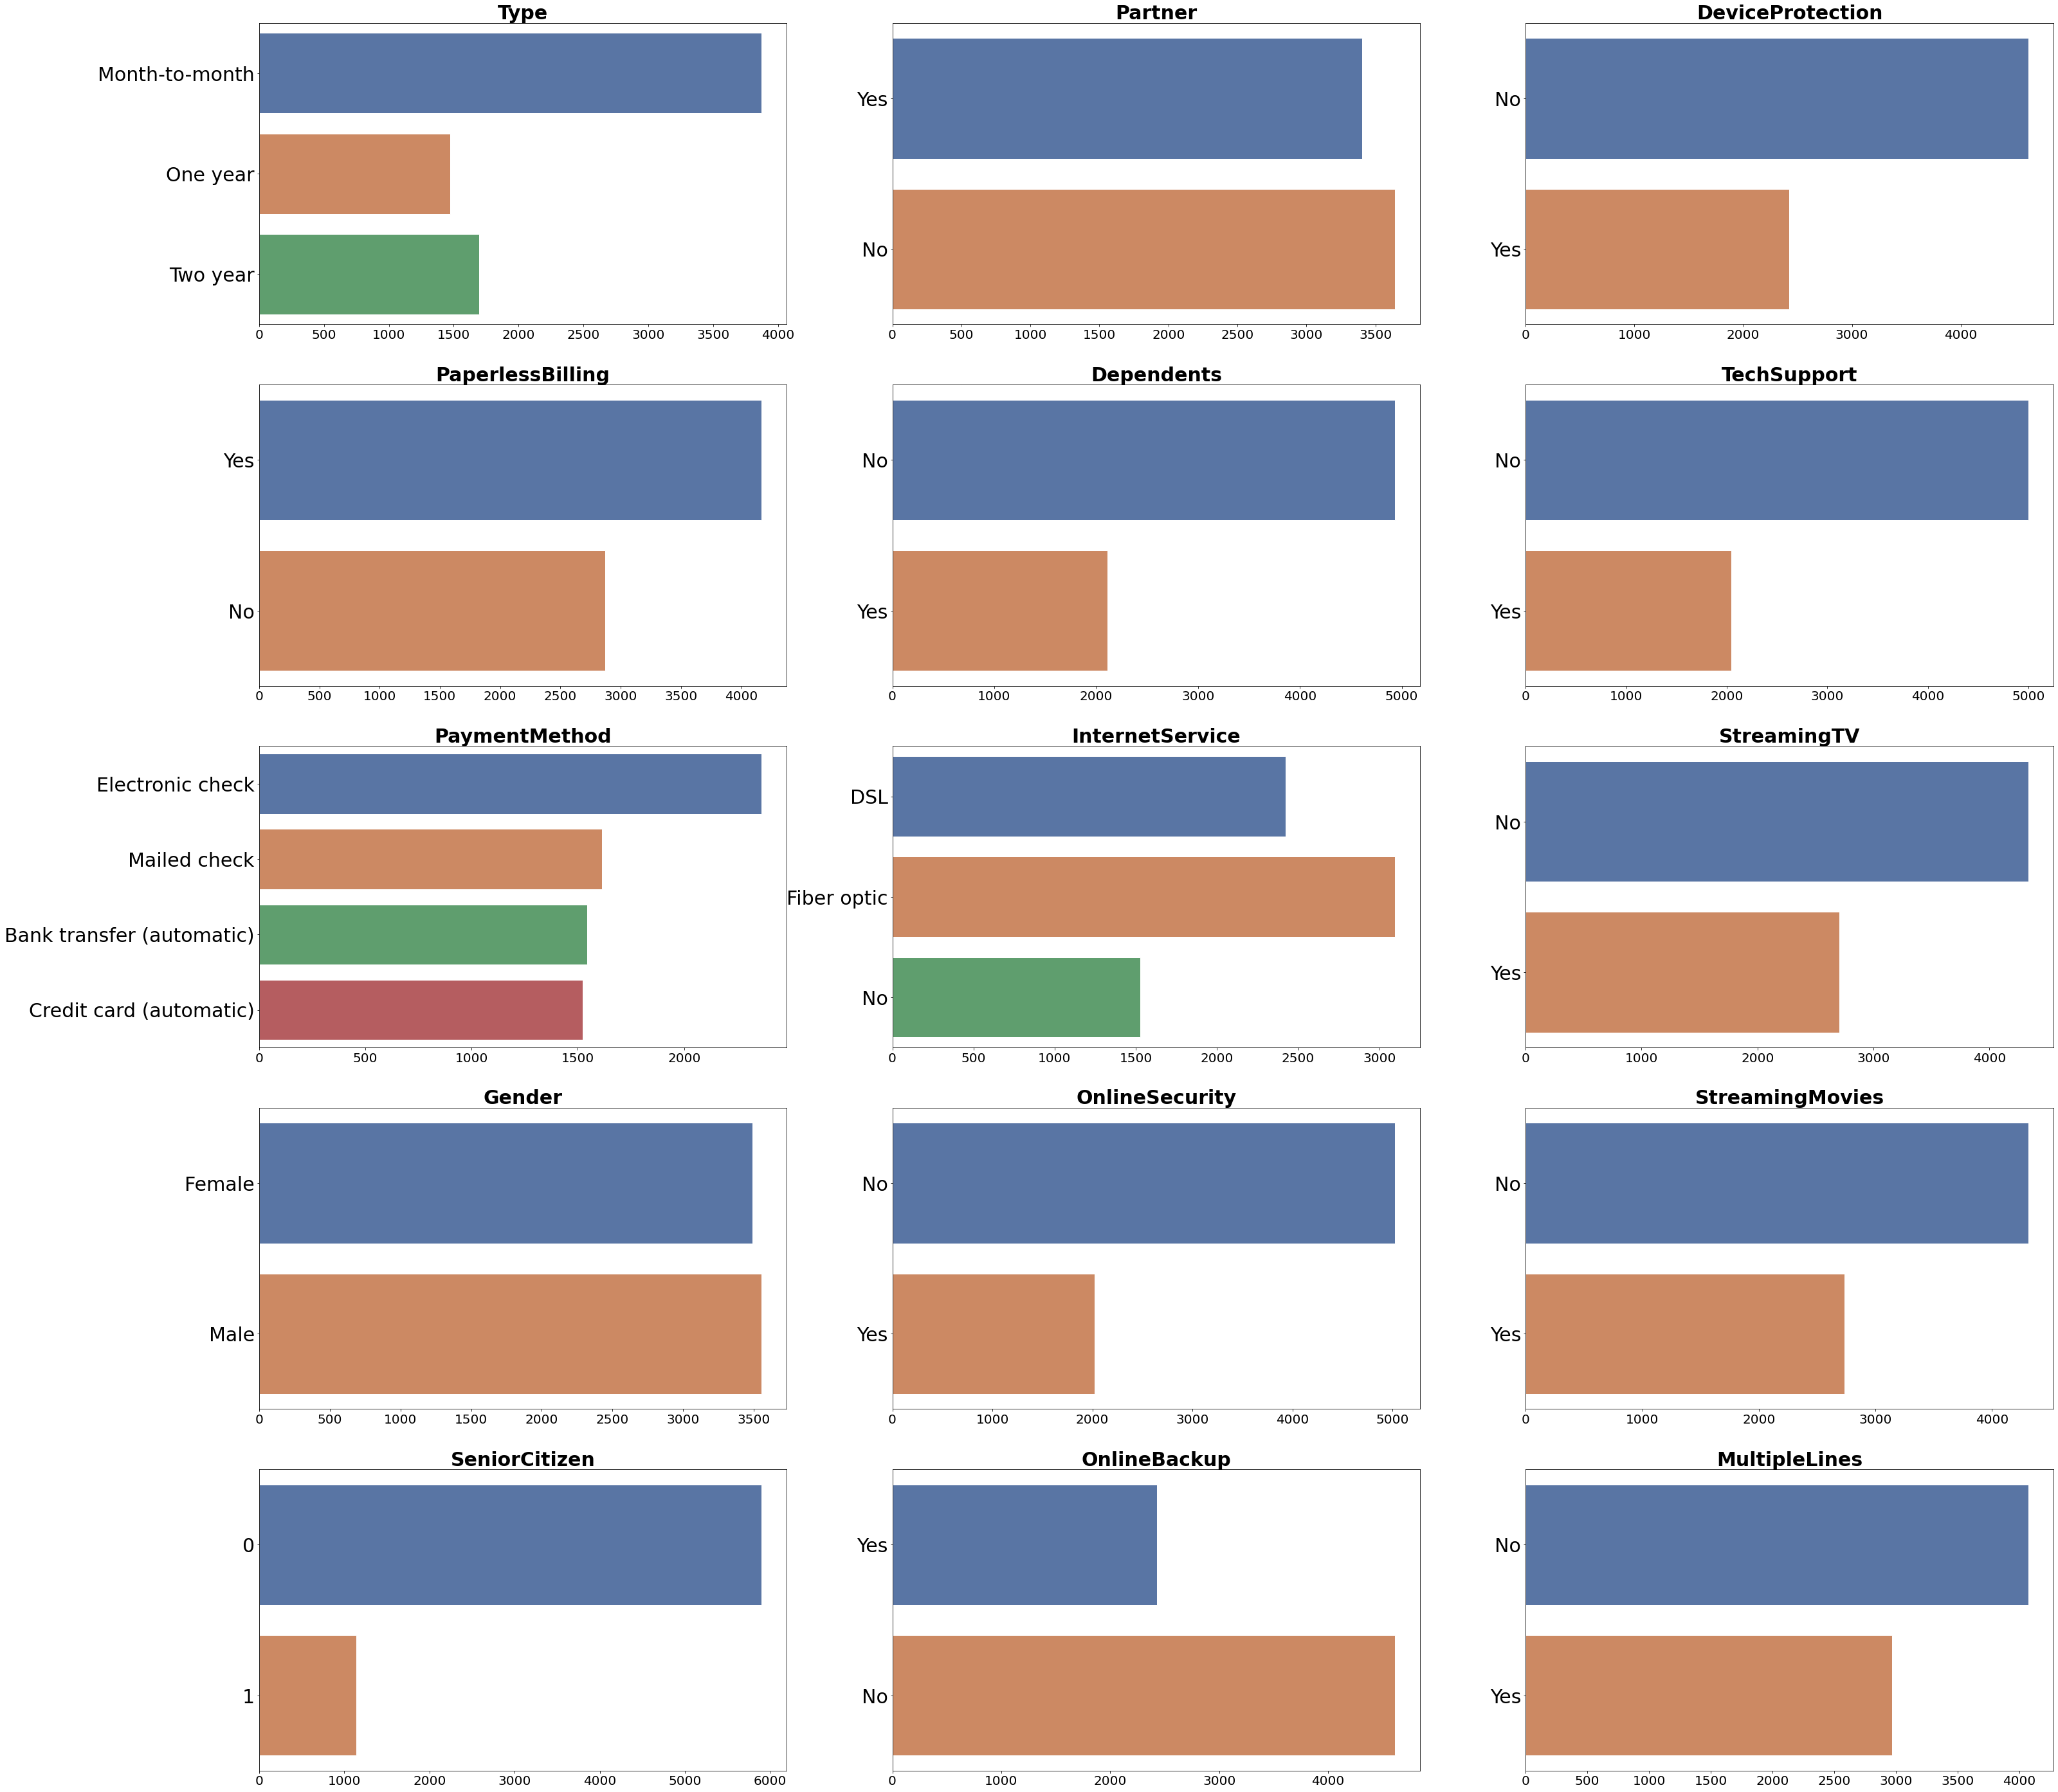

In [28]:
fig, axs = plt.subplots(ncols=cols, nrows=rows)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(50,50)

sns.countplot(ax=axs[0,0], y='Type', data=final_df)
axs[0,0].set_title(label = 'Type', size=30, weight='bold')
axs[0,0].set_xlabel('', fontdict={'fontsize' : 10})
axs[0,0].set_ylabel('', fontdict={'fontsize' : 10})

sns.countplot(ax=axs[1,0], y='PaperlessBilling', data=final_df)
axs[1,0].set_title(label = 'PaperlessBilling', size=30, weight='bold')
axs[1,0].set_xlabel('', fontdict={'fontsize' : 10})
axs[1,0].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[2,0], y='PaymentMethod', data=final_df)
axs[2,0].set_title(label = 'PaymentMethod', size=30, weight='bold')
axs[2,0].set_xlabel('', fontdict={'fontsize' : 10})
axs[2,0].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[3,0], y='Gender', data=final_df)
axs[3,0].set_title(label = 'Gender', size=30, weight='bold')
axs[3,0].set_xlabel('', fontdict={'fontsize' : 10})
axs[3,0].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[4,0], y='SeniorCitizen', data=final_df)
axs[4,0].set_title(label = 'SeniorCitizen', size=30, weight='bold')
axs[4,0].set_xlabel('', fontdict={'fontsize' : 10})
axs[4,0].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[0,1], y='Partner', data=final_df)
axs[0,1].set_title(label = 'Partner', size=30, weight='bold')
axs[0,1].set_xlabel('', fontdict={'fontsize' : 10})
axs[0,1].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[1,1], y='Dependents', data=final_df)
axs[1,1].set_title(label = 'Dependents', size=30, weight='bold')
axs[1,1].set_xlabel('', fontdict={'fontsize' : 10})
axs[1,1].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[2,1], y='InternetService', data=final_df)
axs[2,1].set_title(label = 'InternetService', size=30, weight='bold')
axs[2,1].set_xlabel('', fontdict={'fontsize' : 10})
axs[2,1].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[3,1], y='OnlineSecurity', data=final_df)
axs[3,1].set_title(label = 'OnlineSecurity', size=30, weight='bold')
axs[3,1].set_xlabel('', fontdict={'fontsize' : 10})
axs[3,1].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[4,1], y='OnlineBackup', data=final_df)
axs[4,1].set_title(label = 'OnlineBackup', size=30, weight='bold')
axs[4,1].set_xlabel('', fontdict={'fontsize' : 10})
axs[4,1].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[0,2], y='DeviceProtection', data=final_df)
axs[0,2].set_title(label = 'DeviceProtection', size=30, weight='bold')
axs[0,2].set_xlabel('', fontdict={'fontsize' : 10})
axs[0,2].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[1,2], y='TechSupport', data=final_df)
axs[1,2].set_title(label = 'TechSupport', size=30, weight='bold')
axs[1,2].set_xlabel('', fontdict={'fontsize' : 10})
axs[1,2].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[2,2], y='StreamingTV', data=final_df)
axs[2,2].set_title(label = 'StreamingTV', size=30, weight='bold')
axs[2,2].set_xlabel('', fontdict={'fontsize' : 10})
axs[2,2].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[3,2], y='StreamingMovies', data=final_df)
axs[3,2].set_title(label = 'StreamingMovies', size=30, weight='bold')
axs[3,2].set_xlabel('', fontdict={'fontsize' : 10})
axs[3,2].set_ylabel('', fontdict={'fontsize' : 10})


sns.countplot(ax=axs[4,2], y='MultipleLines', data=final_df)
axs[4,2].set_title(label = 'MultipleLines', size=30, weight='bold')
axs[4,2].set_xlabel('', fontdict={'fontsize' : 10})
axs[4,2].set_ylabel('', fontdict={'fontsize' : 10})

- Наиболее частый способ оплаты - помесячный
- Люди чаще предпочитают оплачивать счета при помощи электронного чека
- Популярный способ подключения - оптоволокно
- Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines непопулярны у пользователей

Проанализируем распредления категориальных признаков относительно целевого признака.

Text(0.5, 1.0, 'MultipleLines')

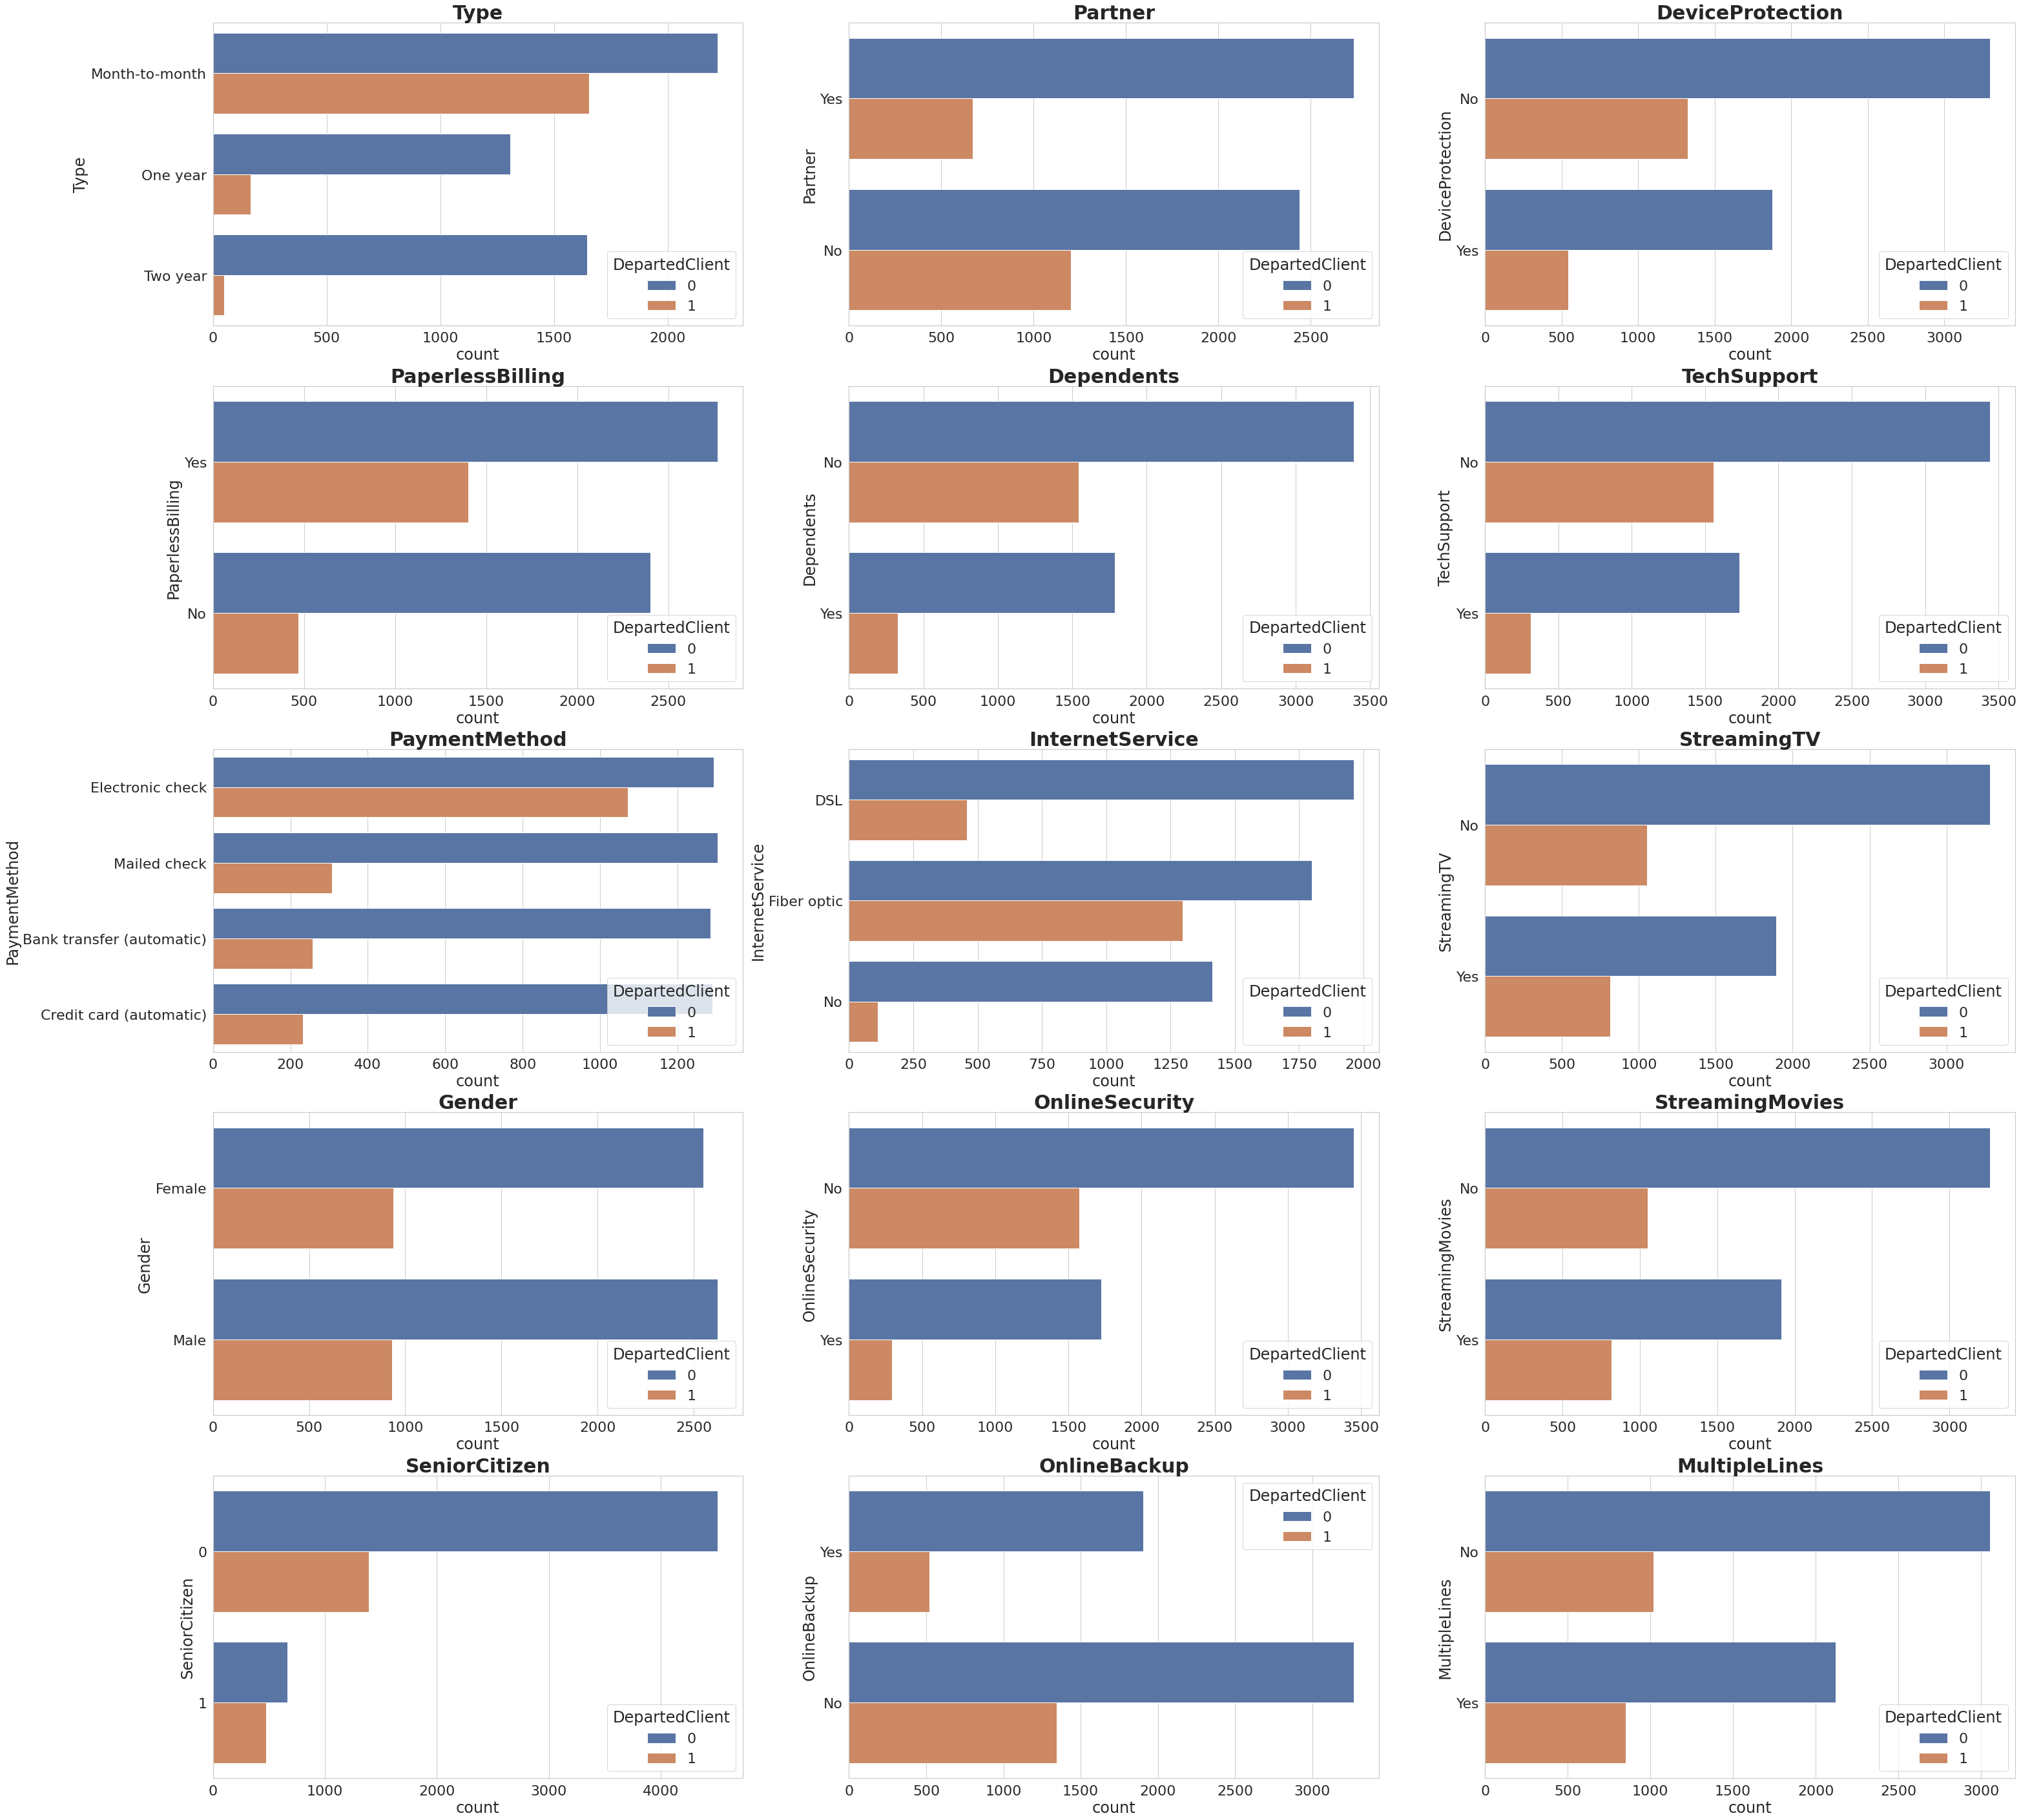

In [29]:
fig, axs = plt.subplots(ncols=cols, nrows=rows)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(50,50)

sns.countplot(ax=axs[0,0], y='Type', data=final_df, hue="DepartedClient")
axs[0,0].set_title(label = 'Type', size=30, weight='bold')

sns.countplot(ax=axs[1,0], y='PaperlessBilling', data=final_df, hue="DepartedClient")
axs[1,0].set_title(label = 'PaperlessBilling', size=30, weight='bold')

sns.countplot(ax=axs[2,0], y='PaymentMethod', data=final_df, hue="DepartedClient")
axs[2,0].set_title(label = 'PaymentMethod', size=30, weight='bold')

sns.countplot(ax=axs[3,0], y='Gender', data=final_df, hue="DepartedClient")
axs[3,0].set_title(label = 'Gender', size=30, weight='bold')

sns.countplot(ax=axs[4,0], y='SeniorCitizen', data=final_df, hue="DepartedClient")
axs[4,0].set_title(label = 'SeniorCitizen', size=30, weight='bold')

sns.countplot(ax=axs[0,1], y='Partner', data=final_df, hue="DepartedClient")
axs[0,1].set_title(label = 'Partner', size=30, weight='bold')

sns.countplot(ax=axs[1,1], y='Dependents', data=final_df, hue="DepartedClient")
axs[1,1].set_title(label = 'Dependents', size=30, weight='bold')

sns.countplot(ax=axs[2,1], y='InternetService', data=final_df, hue="DepartedClient")
axs[2,1].set_title(label = 'InternetService', size=30, weight='bold')

sns.countplot(ax=axs[3,1], y='OnlineSecurity', data=final_df, hue="DepartedClient")
axs[3,1].set_title(label = 'OnlineSecurity', size=30, weight='bold')

sns.countplot(ax=axs[4,1], y='OnlineBackup', data=final_df, hue="DepartedClient")
axs[4,1].set_title(label = 'OnlineBackup', size=30, weight='bold')

sns.countplot(ax=axs[0,2], y='DeviceProtection', data=final_df, hue="DepartedClient")
axs[0,2].set_title(label = 'DeviceProtection', size=30, weight='bold')

sns.countplot(ax=axs[1,2], y='TechSupport', data=final_df, hue="DepartedClient")
axs[1,2].set_title(label = 'TechSupport', size=30, weight='bold')

sns.countplot(ax=axs[2,2], y='StreamingTV', data=final_df, hue="DepartedClient")
axs[2,2].set_title(label = 'StreamingTV', size=30, weight='bold')

sns.countplot(ax=axs[3,2], y='StreamingMovies', data=final_df, hue="DepartedClient")
axs[3,2].set_title(label = 'StreamingMovies', size=30, weight='bold')

sns.countplot(ax=axs[4,2], y='MultipleLines', data=final_df, hue="DepartedClient")
axs[4,2].set_title(label = 'MultipleLines', size=30, weight='bold')

- Допуслуги слабо влияют на отказы
- Люди с помесячной оплаты уходят чаще, чем люди с годовой/двухгодовой оплатой
- Пожилые люди уходят чаще
- Люди использующие электронную оплату уходят чаще, вероятно с ней есть какие-либо проблемы
- Вероятность ухода меньше, если клиент не пользуется интернетом

Проанализируем количественные данные.

Text(0.5, 1.0, 'TotalDays')

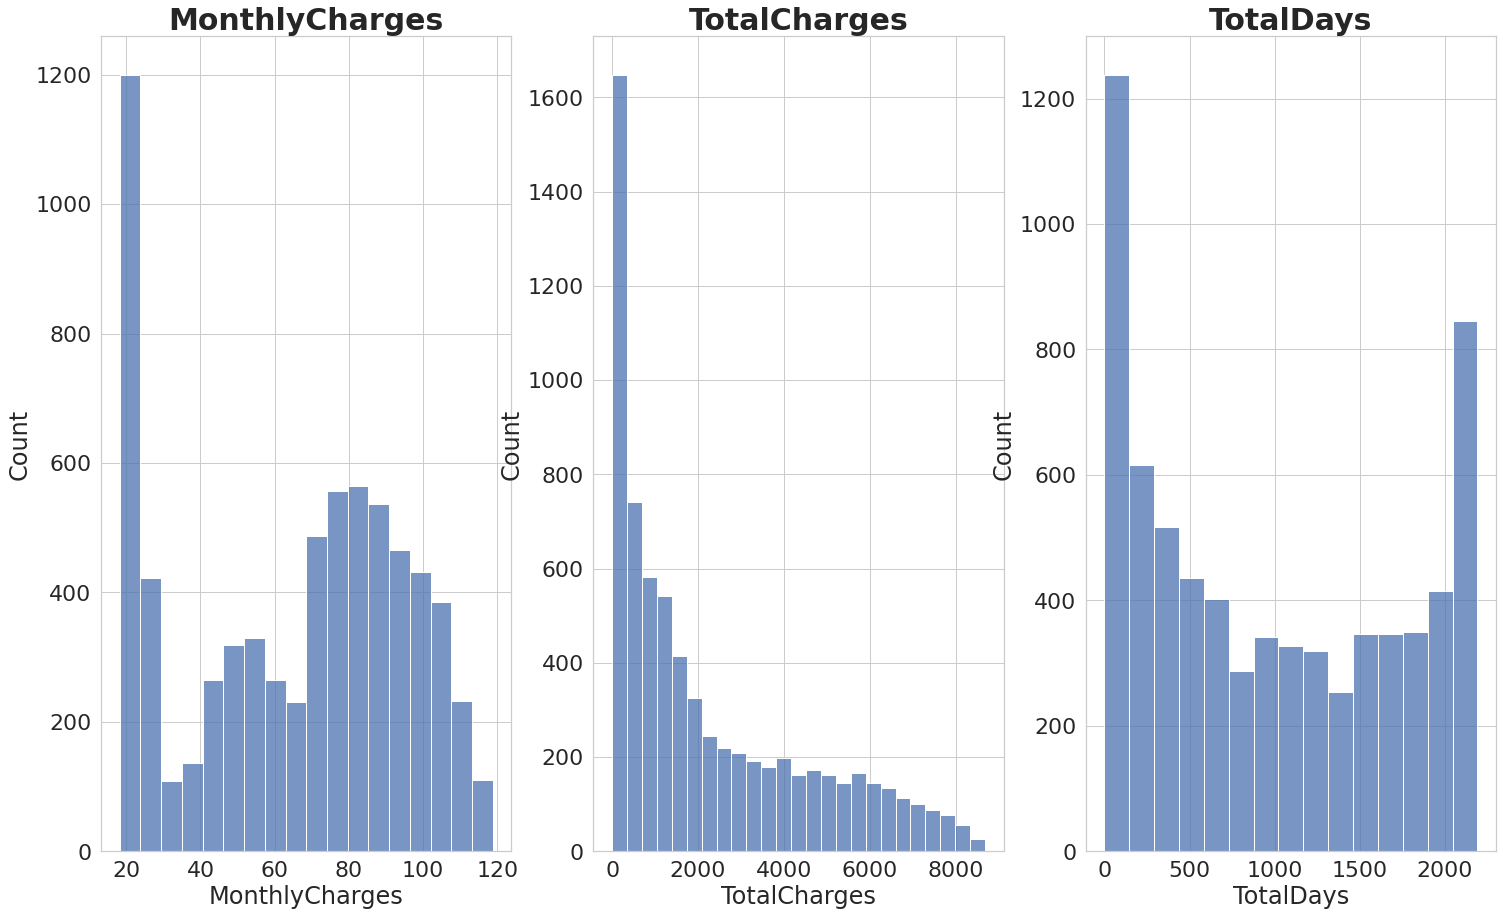

In [30]:
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(25,15)

sns.histplot(ax=axs[0], x='MonthlyCharges', data=final_df)
axs[0].set_title(label = 'MonthlyCharges', size=30, weight='bold')

sns.histplot(ax=axs[1], x='TotalCharges', data=final_df)
axs[1].set_title(label = 'TotalCharges', size=30, weight='bold')

sns.histplot(ax=axs[2], x='TotalDays', data=final_df)
axs[2].set_title(label = 'TotalDays', size=30, weight='bold')

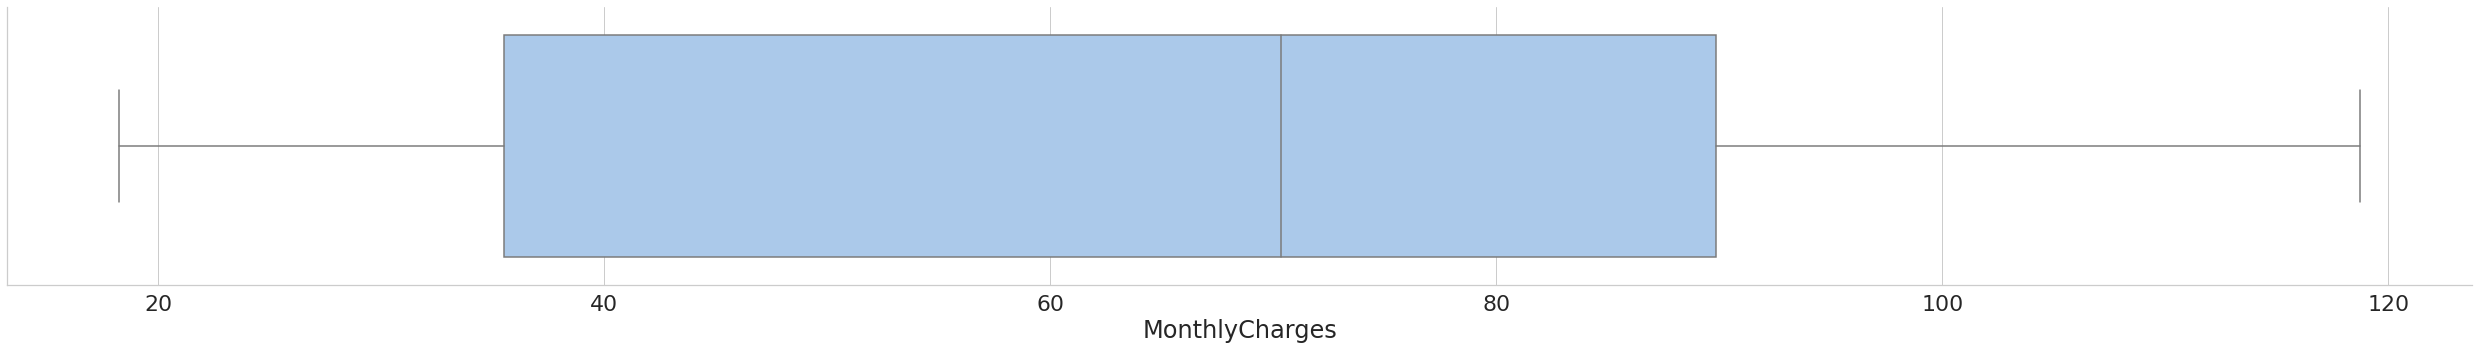

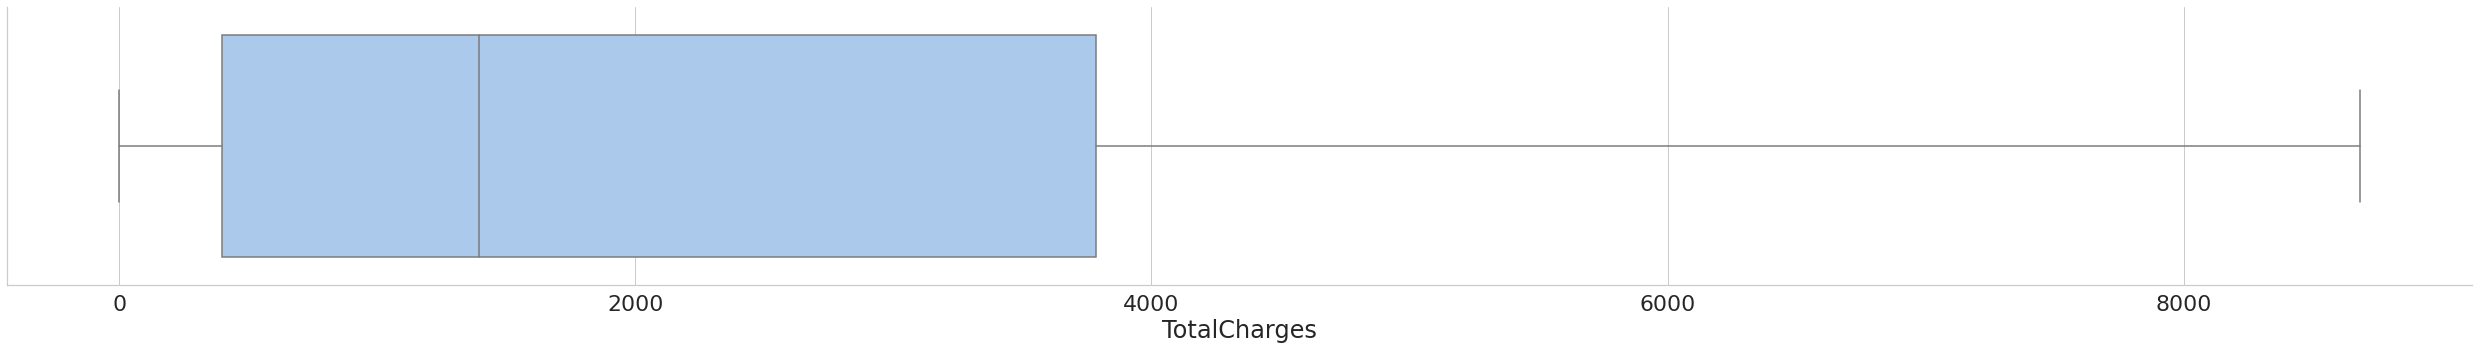

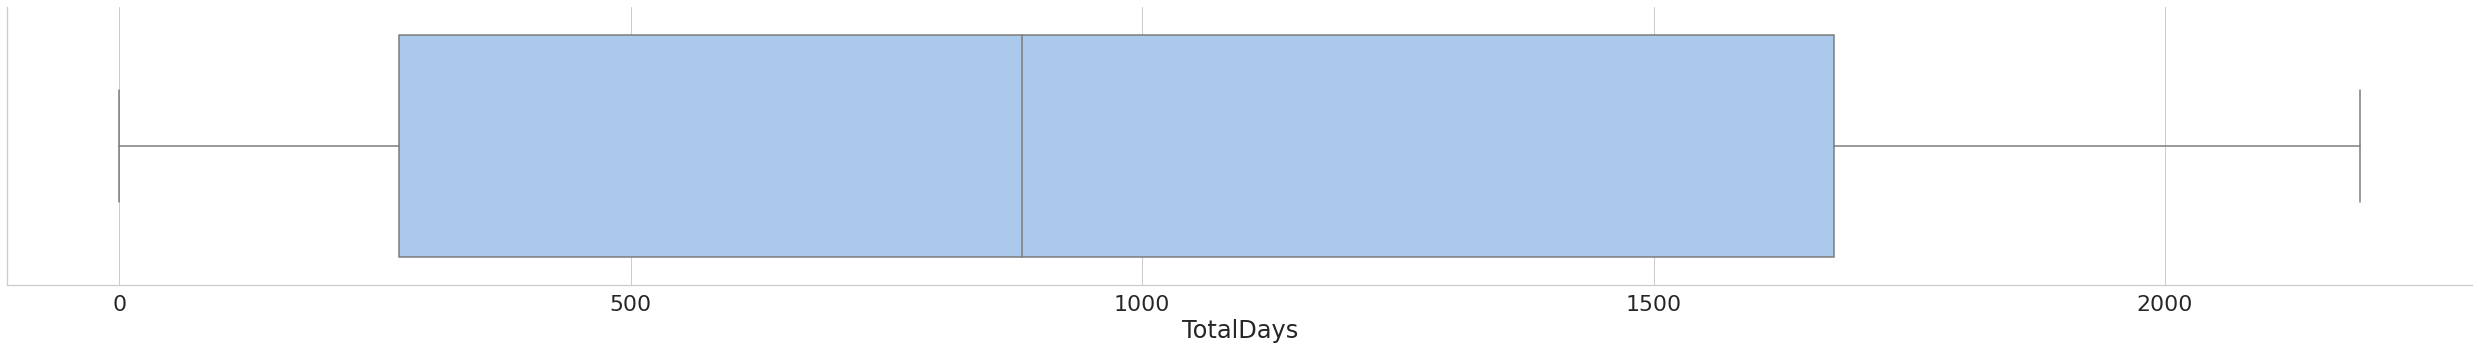

In [31]:
for column in numeric_columns:    
    g = sns.catplot(x=column, kind="box", data=final_df, orient='h', palette = 'pastel')
    g.fig.set_figwidth(40)
    g.fig.set_figheight(5)

- В столбце TotalCharges значения убывают, в столбце MonthlyCharges наблюдаются пики около 20 (минимальное значение) и 85 (клиенты тратящие больше этой суммы, скорее всего уходят со временем)
- В столбце TotalDays наблюдается также два пика в районе новых клиентов и клиентов-долгожителей
- Аномальных выбросов не обнаружено

Проанализируем количественные данные относительно целевого признака.

Text(0.5, 1.0, 'TotalDays')

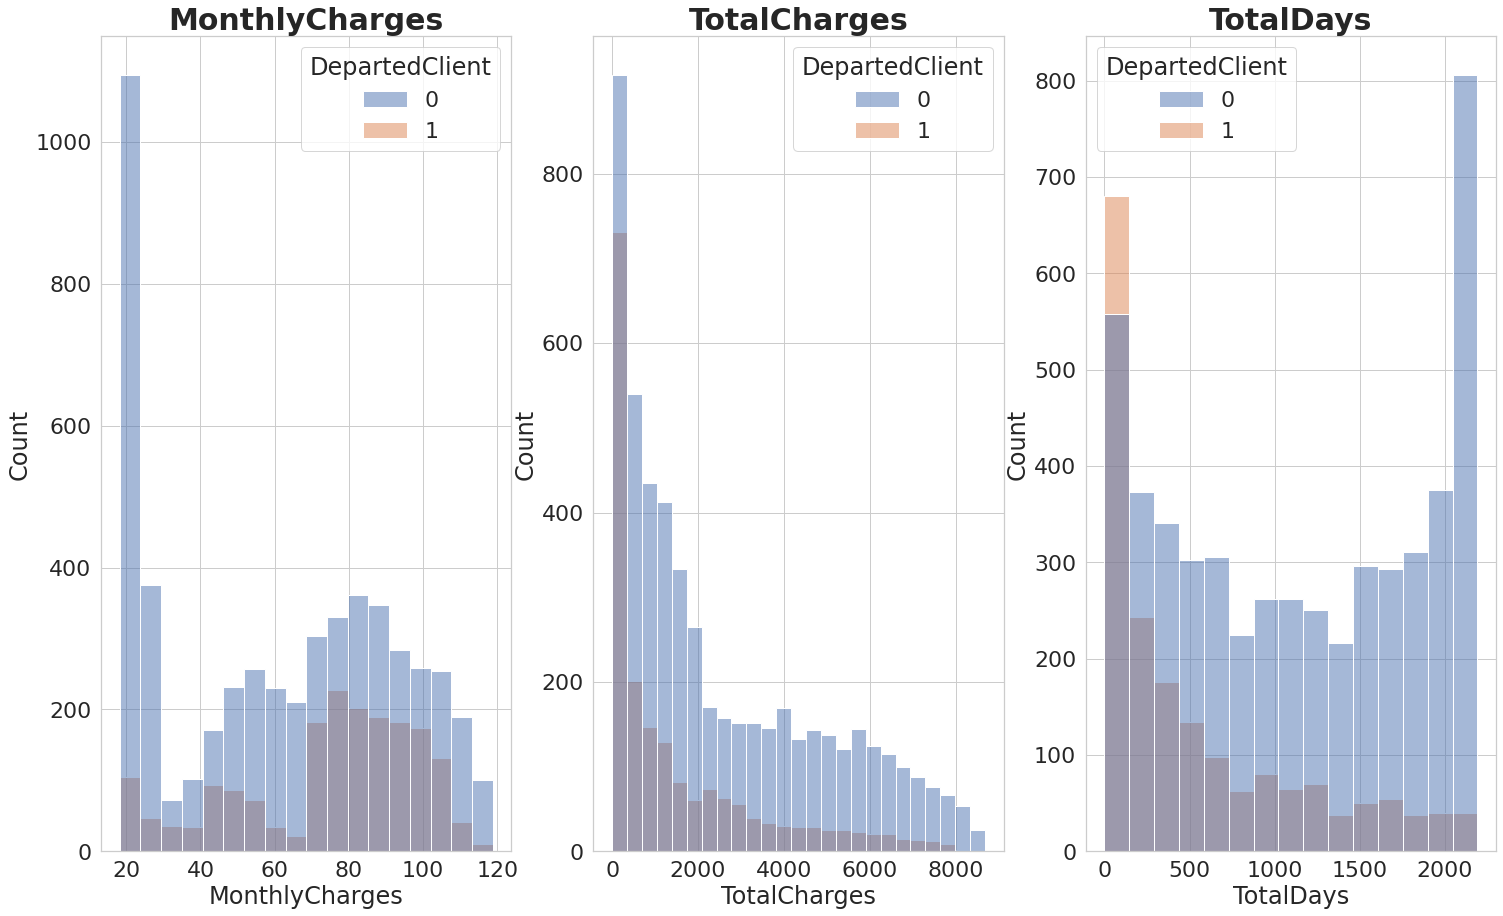

In [32]:
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(25,15)

sns.histplot(ax=axs[0], x='MonthlyCharges', data=final_df, hue="DepartedClient")
axs[0].set_title(label = 'MonthlyCharges', size=30, weight='bold')

sns.histplot(ax=axs[1], x='TotalCharges', data=final_df, hue="DepartedClient")
axs[1].set_title(label = 'TotalCharges', size=30, weight='bold')

sns.histplot(ax=axs[2], x='TotalDays', data=final_df, hue="DepartedClient")
axs[2].set_title(label = 'TotalDays', size=30, weight='bold')

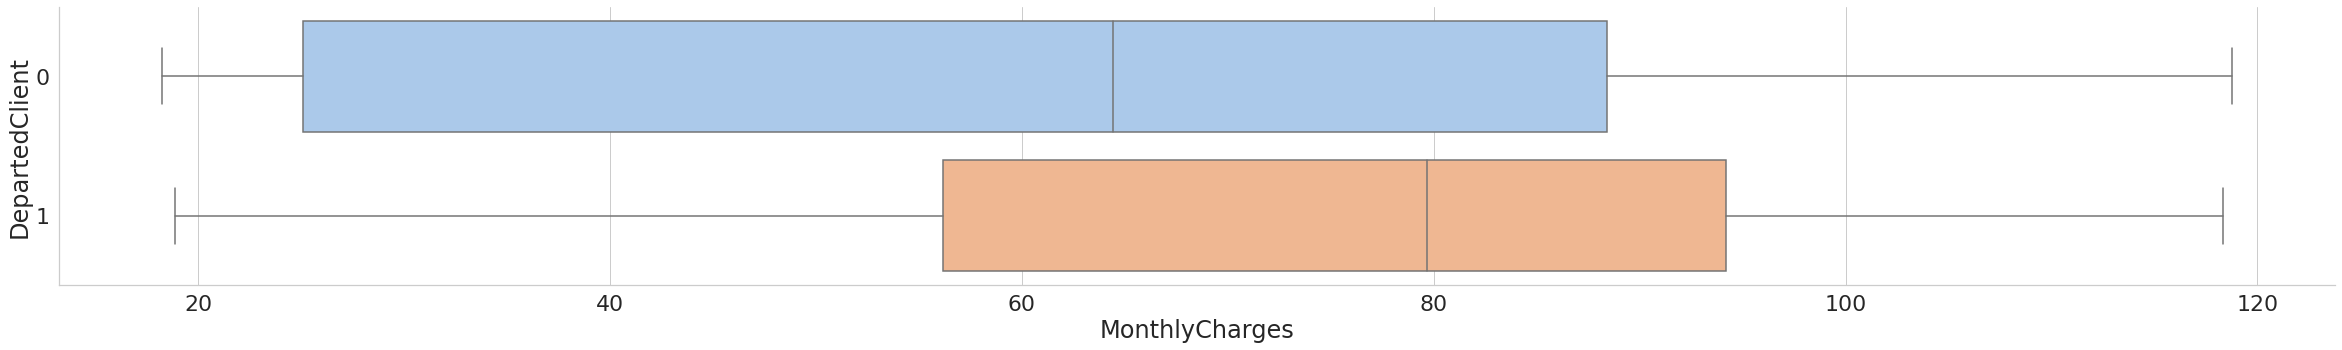

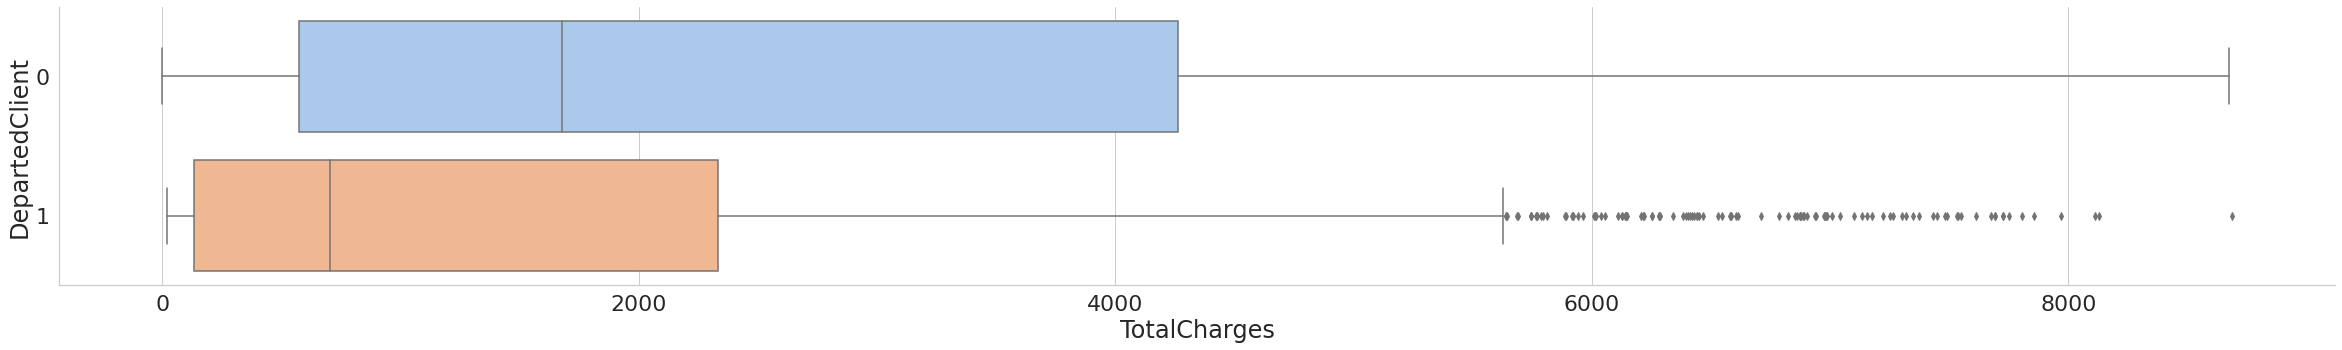

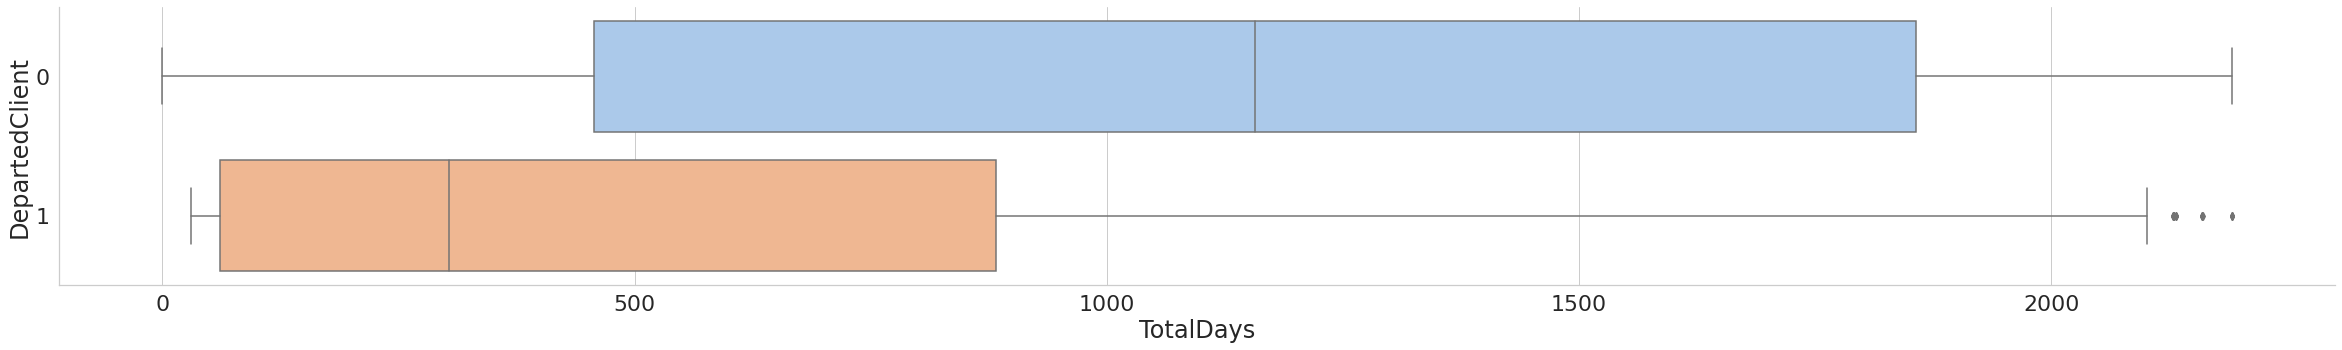

In [33]:
for column in numeric_columns:    
    g = sns.catplot(y='DepartedClient', x=column, kind="box", data=final_df, orient='h', palette = 'pastel')
    g.fig.set_figwidth(40)
    g.fig.set_figheight(5)

- Со временем вероятность ухода клиента снижается
- Отказываются от услуг чаще те, кто много платил
- Активные клиенты платят в месяц в среднем меньше, чем те кто ушел

Проверим корреляцию количественных признаков.

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.651174,0.247754
TotalCharges,0.651174,1.000000,0.826109
TotalDays,0.247754,0.826109,1.000000


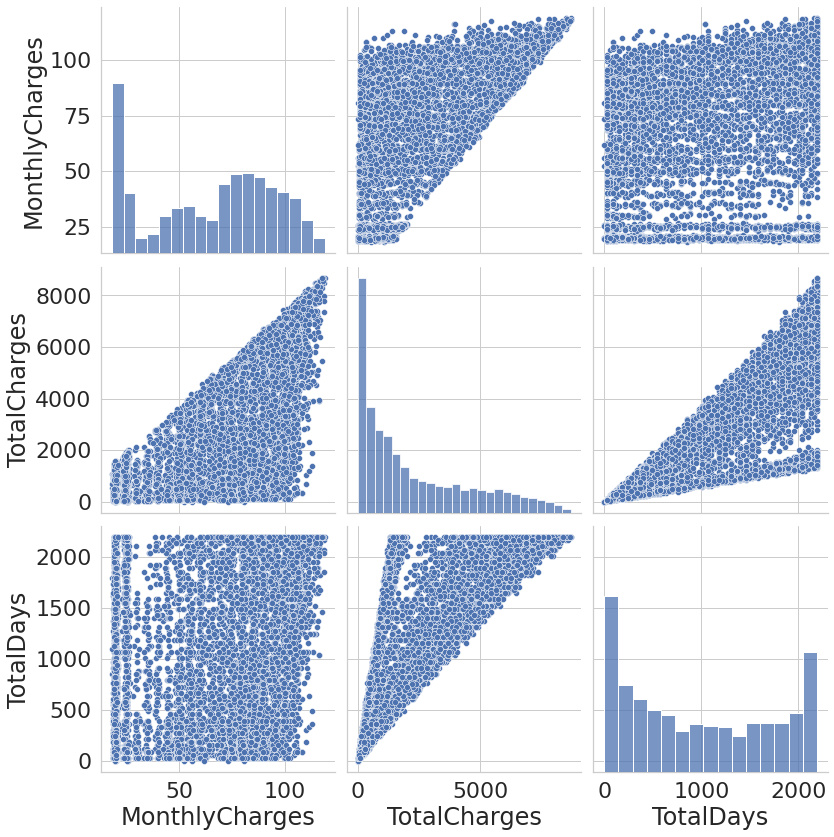

In [34]:
sns.pairplot(final_df[numeric_columns],size = 4)
final_df[numeric_columns].corr()

Столбцы TotalCharges и TotalDays сильно коррелируют, это очевидно - чем больше клиент пользуется услугами, тем больше он платит. Удалим столбец TotalCharges.

In [35]:
del final_df['TotalCharges']
numeric_columns = ['MonthlyCharges', 'TotalDays']

# Подготовка данных для обучения моделей

Удалим ненужные для обучения моделей столбцы BeginDate и EndDate.

In [36]:
del final_df['BeginDate'], final_df['EndDate']

Заменим индексы на идентификаторы клиентов.

In [37]:
final_df = final_df.set_index('CustomerID')

Закодируем категориальные признаки методом OHE.

In [38]:
final_df = pd.get_dummies(final_df, drop_first=True)

In [39]:
final_df.head(5)

,MonthlyCharges,DepartedClient,TotalDays,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,0,1036,0,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,1,61,0,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,0,1371,0,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,1,61,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


Выделяем целевой и остальные признаки.

In [40]:
target = final_df['DepartedClient'] 
features = final_df.drop(columns=['DepartedClient'])

Делим выборку на тренировочную и тестовую.

In [41]:
features_train,features_test,target_train,target_test = train_test_split(features,
                                                                         target,
                                                                         test_size=0.2,
                                                                         random_state=RANDOM_STATE)

Отмасштабируем количественные признаки.

In [42]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

#features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

#features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

/tmp/ipykernel_90/4000171990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_90/4000171990.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Обучение моделей

## Logistic Regression

In [46]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
LR = search.fit(features_train, target_train)

print(search.best_params_)

#predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'C': 10}


In [47]:
scores = cross_val_score(LR, features_train, target_train, cv=5,scoring='roc_auc')
print("roc_auc: {}".format(scores))
print("mean roc_auc: {:.2f}".format(scores.mean()))

roc_auc: [0.84267231 0.86520919 0.83217363 0.82956127 0.84443099]
mean roc_auc: 0.84


## Random Forest Classifier

In [48]:
param_grid = {
    'max_depth': [2,4,6,8,10,12,14,16],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
RFC = search.fit(features_train, target_train)

print(search.best_params_)

#predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [49]:
scores = cross_val_score(RFC, features_train, target_train, cv=5,scoring='roc_auc')
print("roc_auc: {}".format(scores))
print("mean roc_auc: {:.2f}".format(scores.mean()))

roc_auc: [0.85459895 0.87382454 0.84408509 0.84340536 0.86144471]
mean roc_auc: 0.86


## Cat Boost Classifier

In [50]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
CBC = search.fit(features_train, target_train)

print(search.best_params_)

#predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'iterations': 700, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [51]:
scores = cross_val_score(CBC, features_train, target_train, cv=5,scoring='roc_auc')
print("roc_auc: {}".format(scores))
print("mean roc_auc: {:.2f}".format(scores.mean()))

roc_auc: [0.90450222 0.93257745 0.90950062 0.90197123 0.91878733]
mean roc_auc: 0.91


Наилучшие результаты показала модель основанная на CatBoostClassifier. Значение метрики составило примерно 0.91

# Проверка модели на тестовой выборке

ROC-AUC score 0.9303985979912924


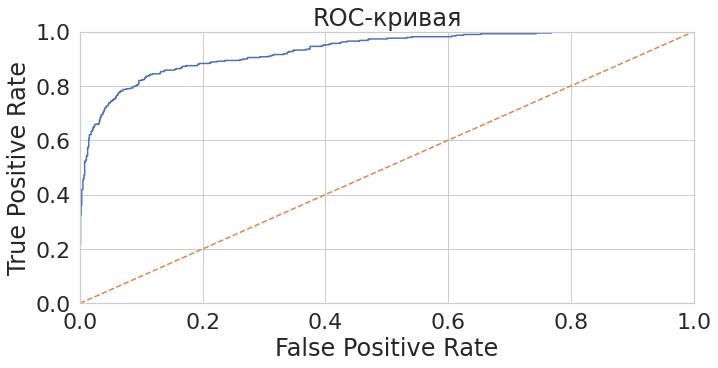

In [52]:
predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, predicted_probalities)

In [ ]:
print('accuracy score', accuracy_score(target_test, predicted_probalities))

# Анализ важности факторов

Прведем анализ важности факторов для обучения модели.

In [53]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
TotalDays,49.360203
MonthlyCharges,14.301906
Type_Two year,3.849722
InternetService_Fiber optic,3.143763
Gender_Male,2.323933
PaperlessBilling_Yes,2.316141
PaymentMethod_Electronic check,2.251220
Type_One year,2.063663
Dependents_Yes,2.014922
TechSupport_Yes,1.975991


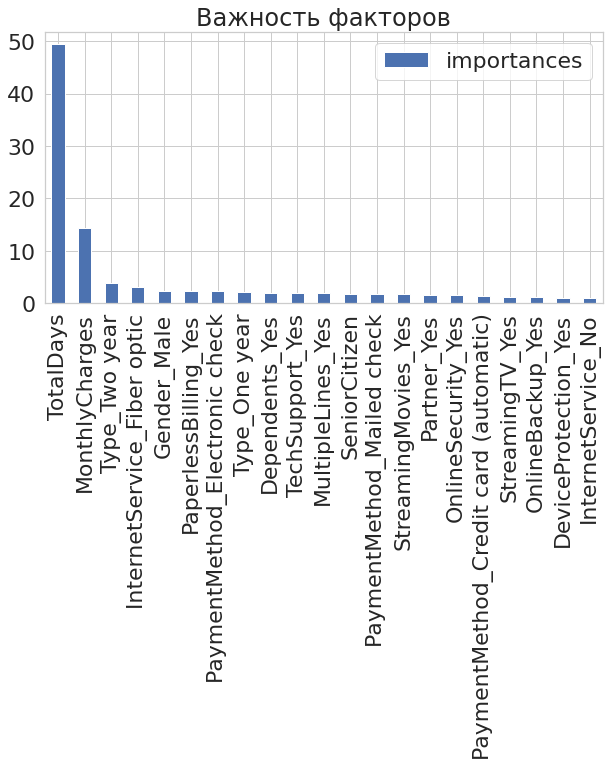

In [54]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

# Выводы

В данном проекте решалась задача по предсказанию отказа клиента от услуг телеком компании.

Был проведен первичный анализ данных, сделаны предварительные выводы. Далее была произведена предобработка данных (изменение названий, изменение типов данных, добавление новых стобцов, поиск пропусков и их заполнение).

Исследовательский анализ данных показал, что вероятность ухода клиента со временем уменьшается, и увеличивается, если клиент тратит на услуги много денег.

Данные были подготовлены для последующего обучения моделей - удалены ненужные столбцы, категориальные признаки были закодированы методом OHE, выборка разделена на тренировочную и тестовую, проведена балансировка данных методом upsampling.

Было обучено три вида моделей - Logistic Regression, Random Forest Classifier, Cat Boost Classifier. Для поиска наилучшего сочетания параметров использовался метод GridSearchCV. Лучшее значение метрики AUC-ROC (0.91) на тренировочной выборке показала модель Cat Boost Classifier. Значение AUC-ROC на тестовой выборке составило 0.93 при использовании обученной модели Cat Boost Classifier.

Наиболее важными факторами оказались сколько пользуется услугами клиент и какие у него ежемесячные затраты. Это те условия, на которые нужно обращать внимание бизнесу при удержании клиента в случае ухода.

# Отчет по выполненной работе

В данной работе решалась задача классификации - было необходимо обучить модель, которая бы прогнозировала отказ клиента от услуг телеком компании.

Были выполнены следующие этапы работы над проектом:
- проведена предобработка данных: 

названия столбцов приведены к одному стилю; изменены типы данных столбцов BeginDate и EndDate на datetime, TotalCharges на числовой; добавлены столбец DepartedClient показывающий, отказался от услуг или нет клиент компании, и столбец TotalDays показывающий, как долго клиент пользуется услугами компании; заполнены пропуски в столбце TotalCharges на дату выгрузки данных; все таблицы были объединены в одну по столбцу CustomerID; появившиеся пропуски в столбцах 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' были заполнены значением 'No', т.к. скорее всего это означает что клиенты не пользуются этими услугами
- выполнен исследовательский анализ данных: 

столбцы разделены на категориальные и числовые признаки; построены гистограммы распределения каждого из категориальных признаков и гистограммы распределения (countplot) каждого из категориальных признаков относительно целевого признака DepartedClient, сделаны некоторые выводы по этим распределениям; для количественных признаков были также построены гистограммы распределения (histplot), коробочные диаграммы (catplot(kind = 'box')) и гистограммы распределения (histplot), коробочные диаграммы (catplot(kind = 'box')) относительно целевого признака DepartedClient, сделаны некоторые выводы; проверена корреляция количественных признаков - TotalCharges и TotalDays сильно коррелируют, столбец TotalCharges был удален
- проведена подготовка данных для последующего обучения моделей:

удалены столбцы BeginDate и EndDate, т.к. они не понадобятся для обучения моделей; категориальные признаки были закодированны методом OHE (этих признаков не так много, поэтому можно воспользоваться этим методом); проведено разделение признаков на целевой и остальные; проведено разделение на тренировочную и тестовую выборки в соотношении 4:1 методом train_test_split (random_state = 120922); количественные признаки были отмасштабированны методом StandardScaler; первоначально была проведена балансировка классов методом upsampling, но в последствии от нее отказались, т.к. она провоцировала утечку данных
- на тренировочных данных было обучено 3 модели:

    - LogisticRegression: 
    
    подбор оптимальных параметров для модели выполнялся методом GridSearchCV (cv = 5, param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, scoring='roc_auc'), далее методом cross_val_score(cv = 5) расчитаны значения auc-roc и посчитано среднее значение auc-roc на тренировочной выборке, оно составило 0.84
        
    - RandomForestClassifier: 
    
    подбор оптимальных параметров для модели выполнялся методом GridSearchCV (cv = 5, param_grid = { 'max_depth': [2,4,6,8,10,12,14,16],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100]}, scoring='roc_auc'), далее методом cross_val_score(cv = 5) расчитаны значения auc-roc и посчитано среднее значение auc-roc на тренировочной выборке, оно составило 0.86
        
    - CatBoostClassifier: 
    
    подбор оптимальных параметров для модели выполнялся методом GridSearchCV (cv = 5, param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900],
    'l2_leaf_reg': [3, 9]}, scoring='roc_auc'), далее методом cross_val_score(cv = 5) расчитаны значения auc-roc и посчитано среднее значение auc-roc на тренировочной выборке, оно составило 0.91
    
    
- в результате подбора моделей лучшей по значению auc-roc оказалась модель градиентного бустинга CatBoostClassifier, она была проверена на тестовой выборке - значение auc-roc составило 0.93, accuracy - 0.89

- также был проведен анализ важности факторов для обучения модели в данной задаче, наиболее важными факторами оказались сколько пользуется услугами клиент и какие у него ежемесячные затраты, это те условия, на которые нужно обращать внимание бизнесу при удержании клиента в случае его ухода

- в ходе выполнения данного проекта особых трудностей не возникало, выполнение шло согласно плану определенному ранее